## **Deep Learning avec LSTM (mémoire à long terme) :**

In [2]:
import os  
import re
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from pathlib import Path
sns.set_theme(style="whitegrid", palette="pastel")
from matplotlib import rcParams



from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
BASE_DIR = Path().resolve().parent
DATA_DIR = BASE_DIR / 'Data' 

df = pd.read_csv(DATA_DIR / 'Top_1000_IMDb_movies.csv')
df.head(3)

,Unnamed: 0,Movie Name,Year of Release,Watch Time,Movie Rating,Metascore of movie,Gross,Votes,Description
0,0,The Shawshank Redemption,1994,142,9.3,82.0,28.34,"27,77,378","Over the course of several years, two convicts..."
1,1,The Godfather,1972,175,9.2,100.0,134.97,"19,33,588","Don Vito Corleone, head of a mafia family, dec..."
2,2,The Dark Knight,2008,152,9.0,84.0,534.86,"27,54,087",When the menace known as the Joker wreaks havo...


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['unnamed:_0', 'movie_name', 'year_of_release', 'watch_time',
       'movie_rating', 'metascore_of_movie', 'gross', 'votes', 'description'],
      dtype='object')

## **VADER**

In [5]:
#Remove Stopwords
import nltk
nltk.download('stopwords') 
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
 
# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

#Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]"," ",text) 
    text = ' '.join(text.split()) 
    return text

#stemming
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence
df['description'] = df['description'].astype(str)
df['description'] = df['description'].apply(lambda x: remove_stopwords(x))
df['description'] = df['description'].apply(lambda x:clean_text(x))
df['description'] = df['description'].apply(stemming)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NAZIFOU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
df['VADER_Sentiment'] = df['description'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Categorize sentiment
df['VADER_Sentiment_Label'] = df['VADER_Sentiment'].apply(lambda score: 'Positive' if score > 0 else ('Negative' if score < 0 else 'Neutral'))

# Print sample results
print(df[['description', 'VADER_Sentiment_Label']].sample(10))

                                           description VADER_Sentiment_Label
591  after break childhood sweetheart young man fin...              Positive
887  three young irish women struggl maintain spiri...              Positive
59   two high school sweetheart meet reunion year r...              Positive
239  renton deepli immers edinburgh drug scene tri ...              Positive
731  a mistaken deliveri mumbai s famous effici lun...              Negative
699  a hot temper farm labor convinc woman love mar...              Positive
487  back sex safe pleasur busi busi boom idealist ...              Positive
379  a disillus colleg graduat find torn older love...              Positive
868  a young boy name kubo must locat magic suit ar...              Negative
814  a video game villain want hero set fulfil drea...              Negative


In [8]:
from sklearn.model_selection import train_test_split
# Diviser l'ensemble de données en ensembles de formation et de test
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['VADER_Sentiment_Label'], test_size=0.2, random_state=42)

In [ ]:
#print(y_train.unique())

## **Entraînement du modèle LSTM (mémoire à long terme)**

In [11]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# 1. Prétraitement des données
# -----------------------------
# Tokenisation
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=200, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=200, padding='post', truncating='post')

# -----------------------------
# 2. Encodage des labels (textes → entiers → one-hot)
# -----------------------------
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)   # 'Negative', 'Neutral', 'Positive' → 0, 1, 2
y_test_encoded = label_encoder.transform(y_test)

y_train_categorical = to_categorical(y_train_encoded, num_classes=3)
y_test_categorical = to_categorical(y_test_encoded, num_classes=3)

print("Ordre des classes :", label_encoder.classes_)

# -----------------------------
# 3. Construction du modèle
# -----------------------------
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128))  # Pas besoin de input_length
model.add(Bidirectional(LSTM(128)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))  # 3 classes

# -----------------------------
# 4. Compilation
# -----------------------------
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# -----------------------------
# 5. Entraînement avec EarlyStopping
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_padded,
    y_train_categorical,
    validation_data=(X_test_padded, y_test_categorical),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# -----------------------------
# 6. Évaluation finale
# -----------------------------
loss, accuracy = model.evaluate(X_test_padded, y_test_categorical)
print(f"✅ Test Accuracy: {accuracy:.4f}")


Ordre des classes : ['Negative' 'Neutral' 'Positive']
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.4770 - loss: 1.0619 - val_accuracy: 0.4350 - val_loss: 1.0467
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.5137 - loss: 1.0045 - val_accuracy: 0.4850 - val_loss: 0.9971
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.6700 - loss: 0.6721 - val_accuracy: 0.5800 - val_loss: 1.1755
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.8432 - loss: 0.3680 - val_accuracy: 0.6050 - val_loss: 1.0959
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.9538 - loss: 0.1692 - val_accuracy: 0.5900 - val_loss: 1.2655
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5161 - loss: 0.9643
✅ Test Accuracy: 0.4850


**Ce qui va bien :**
- L'entraînement se passe bien, pas d'erreur 👍
- Le modèle apprend clairement : accuracy monte jusqu’à 0.95 sur le train
- Le modèle est capable de capter les classes, donc les embeddings + LSTM fonctionnent 


**Problème de surapprentissage (overfitting)**
- Train accuracy : 0.95
- Val accuracy : plafonne autour de 0.48–0.60
- Val loss augmente → le modèle mémorise le training set, mais généralise mal

In [ ]:
#### Sauvegarde du modèle

In [12]:
import pickle

# 1. Sauvegarder le modèle
model.save("sentiment_model.h5")

# 2. Sauvegarder le tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# 3. Sauvegarder le label encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


<Figure size 1600x800 with 0 Axes>

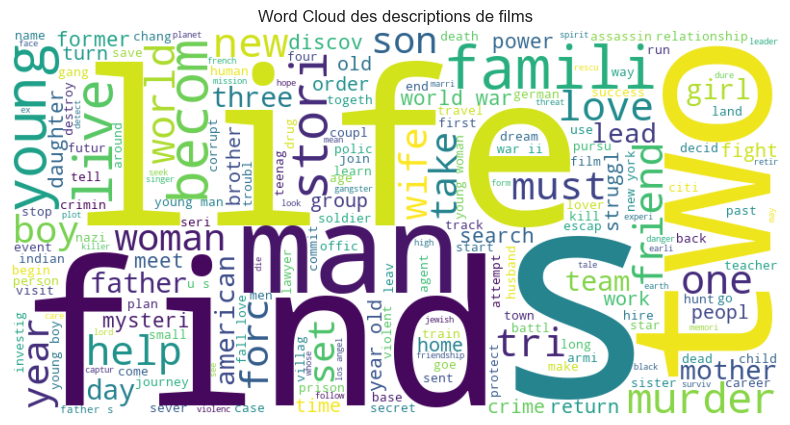

In [21]:
from wordcloud import WordCloud

plt.figure(figsize=(16, 8))
# Concatenate all reviews into a single string
all_reviews = ' '.join(df['description'] )

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud des descriptions de films')
plt.show()